In [0]:
"""
Last edited on Tue april 11 2019
adding better downloaded links functionality as well as using the Optimisation for an open ended MST
implemented by Omar Mohamed Hussein
Cause for this code : Dissertation
due date on the 12th of april
side note : majority of errors are potentially gradient related and matrix size related
"""
import matplotlib.pyplot as plt # Viewing the image
import matplotlib as mpl
import numpy as np
from PIL import Image # for Image processing and CV
import time # amount of time it took
import functools
import tensorflow as tf # tensorflow framework
import tensorflow.contrib.eager as tfe
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import IPython.display # for displays
import os #The OS module in Python provides a way of using operating system dependent functionality

In [0]:
# Download what you wish just be sure it has .jpg extension 
img_dir = '/OmarM.H/Multstyletransfer'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://cdn1.thr.com/sites/default/files/imagecache/scale_crop_768_433/2016/11/vikings_-_still_-_h_-_2016.jpg
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://www.vocfm.co.za/wp-content/uploads/2018/10/fire___Super_Portrait-702x336.jpg

!wget --quiet -P /OmarM.H/Multstyletransfer/ https://static.giantbomb.com/uploads/scale_medium/1/10354/2763938-nathandrake.jpg   
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzhd223El8XbDQOk4NZn9UvVKTUTnaEEV2QyJyQFY66uiRusw5Yw
!wget --quiet -P /OmarM.H/Multstyletransfer/ http://developer.download.nvidia.com/books/HTML/gpugems/elementLinks/fig07-01.jpg  
    
# Style1
!wget --quiet -P /OmarM.H/Multstyletransfer/ http://blog.paperblanks.com/wp-content/uploads/2013/04/Da-Vinci-Great-Works_Ginevra-de-Benci.png 
# image
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://i.pinimg.com/originals/00/1b/d1/001bd1ff5a102d180eb1e60509fd083b.jpg
# Style2
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://shop.tate.org.uk/dw/image/v2/BBPB_PRD/on/demandware.static/-/Sites-TateMasterShop/default/dw0da7102f/pablo-picasso-the-mirror-custom-print-pabpic1817.jpg
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://www.windows2universe.org/mercury/images/messenger_ice_nov302012.jpg 


!wget --quiet -P /OmarM.H/Multstyletransfer/ https://cdn.britannica.com/s:300x300/34/78134-004-8587374E.jpg
!wget --quiet -P /OmarM.H/Multstyletransfer/ http://imagecache5.art.com/LRG/27/2709/IS5ND00Z.jpg
!wget --quiet -P /OmarM.H/Multstyletransfer/ http://img.photobucket.com/albums/v162/boodledrop/charponnaise/vermeer.jpg       
        
        
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://news.artnet.com/app/news-upload/2014/07/Mona_Lisa.jpg
!wget --quiet -P /OmarM.H/Multstyletransfer/ https://static01.nyt.com/images/2016/10/29/science/01DoNKEY-sb1/01DoNKEY-sb1-jumbo.jpg

# New Section

In [0]:
# Figure size
mpl.rcParams['figure.figsize'] = (15,15)
mpl.rcParams['axes.grid'] = False

In [0]:
# immeaditly runnung the tensorflow
tf.enable_eager_execution()


In [0]:
# Set up some global values here
content_path = '/OmarM.H/Multstyletransfer/01DoNKEY-sb1-jumbo.jpg'
style_path = '/OmarM.H/Multstyletransfer/Mona_Lisa.jpg'

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

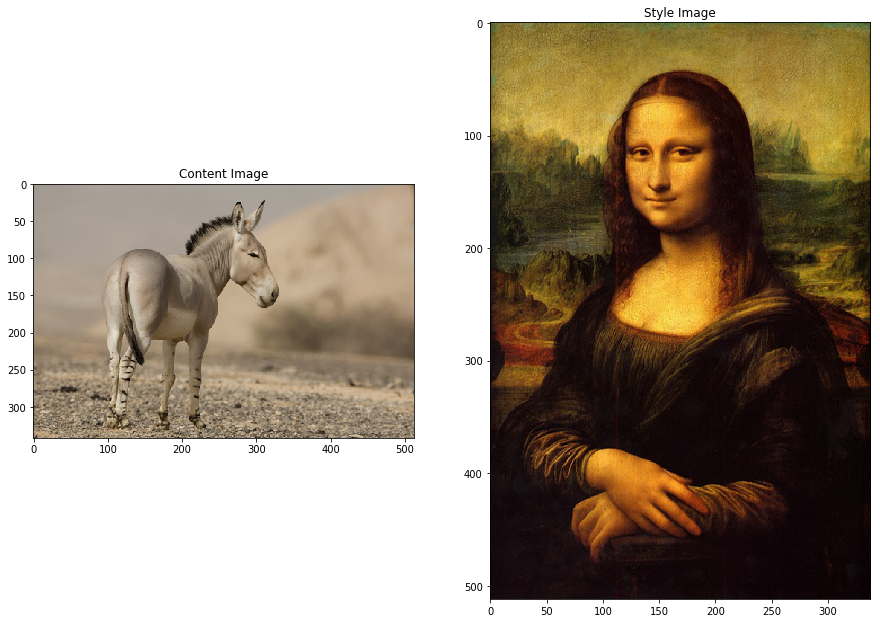

In [9]:
plt.figure(figsize=(15,15))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [0]:
def Vgged(path):
  img = load_img(path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def revert_Vgg(vgged_img):
  x = vgged_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)#5
num_style_layers = len(style_layers)#1

In [0]:
def vgg_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [0]:
def content_cost(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  grammed = gram / tf.cast(n, tf.float32)
  return grammed

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  grammed =tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)
  return grammed

In [0]:
def needed_layers(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = Vgged(content_path)
  style_image = Vgged(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  alpha, beta = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
    
  for target_style, gen in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(gen[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* content_cost(comb_content[0], target_content)
  
  style_score *= style_score *alpha
  content_score *= beta

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  # returning the loss
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
import IPython.display

def neural_style_transfer(content_path, 
                       style_path,
                       num_iterations=700,
                       content_weight=8, 
                       style_weight=0.8): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = vgg_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = needed_layers(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = Vgged(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=6)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/10
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = revert_Vgg(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
    
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = revert_Vgg(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.5e}, ' 
            'style loss: {:.3e}, '
            'content loss: {:.3e}, '
            'time: {:.3f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.3f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])  
  return best_img, best_loss 

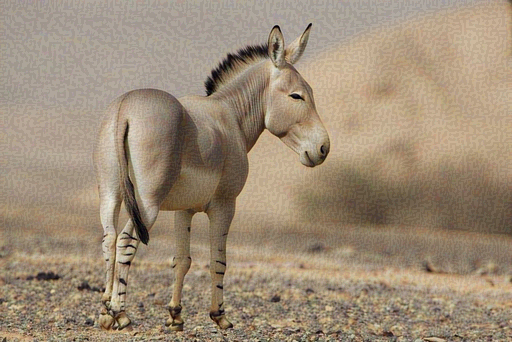

Iteration: 0
Total loss: 7.89801e+19, style loss: 7.898e+19, content loss: 0.000e+00, time: 0.085s


In [0]:
best, best_loss = neural_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

In [0]:
Image.fromarray(best)

In [0]:
def progress(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [0]:
progress(best, content_path, style_path)

In [0]:
content0=input('Please enter the path your desired picture')
content2 = content0
def mst(content2,number_of_styles):
    for s in range(0,number_of_styles):
        style = input('Please enter the path your desired style')
        best, best_loss = neural_style_transfer(content,style)
        content2 = best
        progress(content2, content0, style)